In [1]:
! git clone https://github.com/madhavlab/audsearch.git

Cloning into 'audsearch'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (403/403), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 604 (delta 106), reused 314 (delta 59), pack-reused 201
Receiving objects: 100% (604/604), 105.31 MiB | 13.99 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Updating files: 100% (181/181), done.


In [2]:
!pip install faiss-cpu
!pip install pytorch-lightning==1.9.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 34.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import some necessary packages
import os
import sys
import glob
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
import IPython.display as ipd
from pytorch_lightning.loggers import TensorBoardLogger

DIR ="/content/audsearch"
sys.path.append(DIR+"/src")

## Audio Processing

#### 1. Load audio

Total files at: 114
Reading file from path: /content/audsearch/data/FMA_subset/001193.mp3


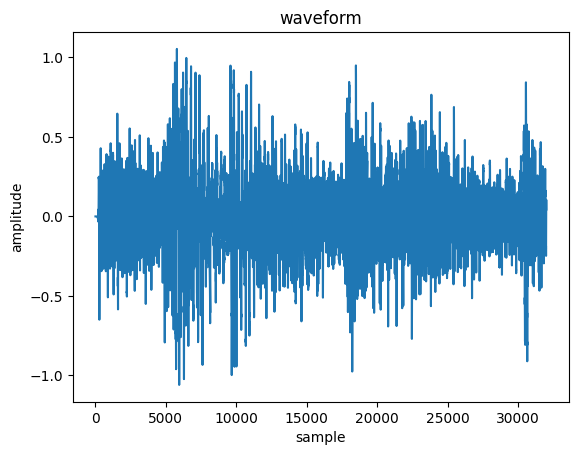

In [5]:
# import our utility class to read an audio and preprocess it, if required
from utils import Audio

# load all files stored in a repository
DATASET_PATH = os.path.join(DIR, "data/FMA_subset")
files = glob.glob(DATASET_PATH+"/**/*.mp3", recursive=True)
print(f"Total files at: {len(files)}")

# randomly read an audio
filepath = np.random.choice(files)
print(f"Reading file from path: {filepath}")
audioreader = Audio(fs=16000, mono=True, normalize=False, preemphasis=False) # resample audio at 16kHZ, if not.
waveform = audioreader.read(filepath)

# plot waveform
plt.title("waveform")
plt.ylabel("amplitude")
plt.xlabel("sample")
fs = 16000 #sampling rate of waveform
start = int(fs*0.0) # start index: fs*time stamp(in seconds)
end = int(fs*2.0) # end index: fs*time stamp(in seconds)
waveform_chunk = waveform[start:end]
plt.plot(waveform_chunk)

In [6]:
# play audio
ipd.Audio(waveform, rate=fs)

#### 2. Time-frequency representation of audio

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


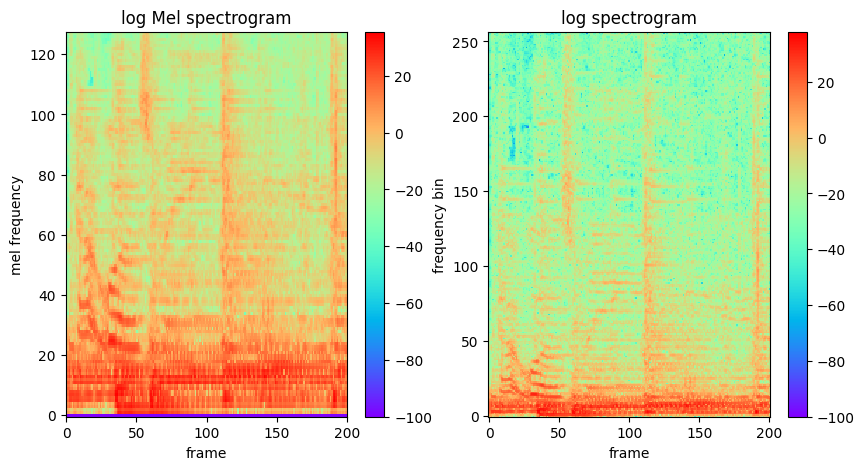

In [7]:
# import our utility class to extract features from an audio
from utils import AudioFeature
import librosa

fs = 16000 # sampling rate of a waveform
n_fft = 512 # window length to compute DFT (in samples)
hop_length = int(fs * 0.01) # window hop length (in samples)
n_mels = 128 # mel filter banks

feat_extractor = AudioFeature(n_fft, hop_length, n_mels, fs)
logMelSpectrum = feat_extractor.get_log_mel_spectrogram(waveform_chunk)
logSpectrum = feat_extractor.get_log_spectrogram(waveform_chunk)

# plotting time-frequency reprentations
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax = ax.flatten()
im1 = ax[0].imshow(logMelSpectrum, origin="lower", aspect="auto", interpolation="nearest", cmap="rainbow")
ax[0].set_ylabel("mel frequency")
ax[0].set_xlabel("frame")
ax[0].set_title("log Mel spectrogram")
fig.colorbar(im1, ax=ax[0], orientation='vertical')

im2 = ax[1].imshow(logSpectrum, origin="lower", aspect="auto", interpolation="nearest", cmap="rainbow")
ax[1].set_ylabel("frequency bin")
ax[1].set_xlabel("frame")
ax[1].set_title("log spectrogram")
fig.colorbar(im2, ax=ax[1],orientation='vertical')

## Fingerprinting

#### 1. Load fingerprint generator

In [8]:
from index import DatabaseBuilder

# necessary inputs to fingerprinter
audiopath = {DATASET_PATH: "mp3"} # directory containing audio files (stored in .mp3 format)

# fingerprinter is basically a trained ML model. <ckpt_path> stores the states of the trained model.
ckpt_path = os.path.join(DIR,"/content/drive/MyDrive/wissap_AFP_tutorial/last.ckpt") #"data/last.ckpt"

# create fingerprinter
builder = DatabaseBuilder(audiopath, ckpt_path, fs=16000, hop=100, seglen=960, audiofeat_params={"n_fft":512, "hop_length":160,"n_mels":64}, fp_dims=128)

# choose a random audio file whose subprints needs to be generated
filepath = np.random.choice(files)

# generate subfingerprints
print("#################### FINGERPRINTING ###########################")
print(f"generating sub fingerprints for audio at: {filepath}")
fp = builder.get_fp(filepath)
print(f"No of subfingerprints: {fp.shape[0]}")
print(f"subfingerprints dimension: {fp.shape[1]}")


Loading files list
Loading fingerprinter...


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'network' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['network'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


Initializing index...
#################### FINGERPRINTING ###########################
generating sub fingerprints for audio at: /content/audsearch/data/FMA_subset/001673.mp3
No of subfingerprints: 291
subfingerprints dimension: 128


#### 2. Building fingerprints database

In [9]:
save_fp_db = [os.path.join(DIR,"FP_dbase"), "EMB_DB.pkl",  "FILES.pkl", "METADATA.pkl"] # contains a path to store fingerprints database and its associated metdata
print(f"Generating fingerprints for {len(files)} audiofiles")
emb_db = builder.create_db(save_fp_db) #builds fingerprints database
print(f"fingerprints database shape: {emb_db.shape}")
print(f"fingerprints database stored at {save_fp_db[0]}")

Generating fingerprints for 114 audiofiles


100%|██████████| 114/114 [00:30<00:00,  3.69it/s]

saving...
fingerprints database shape: (33107, 128)
fingerprints database stored at /content/audsearch/FP_dbase


## Indexing

In [10]:
from index.create_refdbase import build_index

# some necessary input arguments to create an indexer
cfg = { 'save_index_path': os.path.join(DIR,"FP_dbase", "FP.index"),
        'centroids': 100,
        'index_type': "ivfpq",
        'num_codebooks': 8,
        'codewords_bit': 8,
        'nprobe': 100,
        'use_gpu': False,
        'gpu_device': 0 }

# length normalize the audio embeddings
emb_db_normalized = emb_db/np.linalg.norm(emb_db, axis=1).reshape(-1,1)

# build index
index_ = build_index(emb_db_normalized, cfg)

Building index...
Index build time: 2.287367582321167
Saving index at: /content/audsearch/FP_dbase/FP.index


## Audio search

In [11]:
from index import Search
from utils import Augmentations


# load some noises and RIRs to simulate distorted query
noises = glob.glob(os.path.join(DIR,"data/noises/*.wav"))
rirs = glob.glob(os.path.join(DIR,"data/rirs/*.wav"))

dbase_meta = [DIR+"/FP_dbase/METADATA.pkl", DIR+"/FP_dbase/FILES.pkl"] # metadata files created after building the fp database
# Instantiate audio retriever
API = Search(ckpt_path, dbase_meta, index_, mode="cpu")

Loading fingerprinter...


In [12]:
# class providing augmentation functionality
distorter = Augmentations()

# randomly generate a query audio
querypath = np.random.choice(files)
query_audio = audioreader.read(querypath)
query_len = 3 # query length (in seconds)
offset_with_buffer = np.random.randint(len(query_audio) - (fs*(query_len+1)) - 1) # fetch an audio segment from the chosen file

#randomly read a noise and RIR to simulate distorted query
noise = audioreader.read(np.random.choice(noises))
rir = audioreader.read(np.random.choice(rirs))
snr = 5 # noise level (in dB)

#create clean, noise and noise+reverb added query
clean_query = query_audio[offset_with_buffer+fs: offset_with_buffer+fs+(fs*query_len)]
noise_added_query = distorter.add_noise(query_audio[offset_with_buffer+fs: offset_with_buffer+fs+(fs*query_len)], noise, snr)
noise_reverb_added_query = distorter.add_noise_reverb(query_audio[offset_with_buffer:offset_with_buffer+(1+query_len)*fs], noise, snr, rir)[fs: (1+query_len)*fs]
reverb_added_query = distorter.add_reverb(query_audio[offset_with_buffer:offset_with_buffer+(1+query_len)*fs], rir)[fs: (1+query_len)*fs]

Let's hear the audio query and its distorted counterparts

In [13]:
ipd.Audio(clean_query, rate=fs)

In [14]:
ipd.Audio(noise_added_query, rate=fs)

In [15]:
ipd.Audio(reverb_added_query, rate=fs)

In [16]:
ipd.Audio(noise_reverb_added_query, rate=fs)

In [17]:
# search best match for the queries

original_timestamp = (offset_with_buffer+fs)/fs
print(f"Groud truth:\naudio file: {querypath}\ntime stamp: {original_timestamp:.2f}s\n")

query_type=["clean", "noise_added", "reverb_added","noise_reverb_added"]
for i, query in enumerate([clean_query, noise_added_query, reverb_added_query, noise_reverb_added_query]):

    songid, timeoffset, levi  = API.subfingerprints_search(query)
    print(f"{query_type[i]}-->\nRetrieved audio file: {songid}\nRetrieved timestamp: {timeoffset:.2f}s\n")

Groud truth:
audio file: /content/audsearch/data/FMA_subset/003533.mp3
time stamp: 15.66s

clean-->
Retrieved audio file: /content/audsearch/data/FMA_subset/003533.mp3
Retrieved timestamp: 15.70s

noise_added-->
Retrieved audio file: /content/audsearch/data/FMA_subset/003533.mp3
Retrieved timestamp: 15.70s

reverb_added-->
Retrieved audio file: /content/audsearch/data/FMA_subset/003533.mp3
Retrieved timestamp: 15.70s

noise_reverb_added-->
Retrieved audio file: /content/audsearch/data/FMA_subset/003533.mp3
Retrieved timestamp: 15.70s



## Training

In [19]:
# import required modules for training
from models import CustomArch7, ProjectionHead1
from utils import SSLDataset, ContrastiveLoss, CosineSimilarity
from train import ContrastiveModel
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

In [24]:
# Read configuration values for training
with open(os.path.join(DIR, "config/main.yaml")) as f:
    print(f"Reading config file")
    cfg = yaml.load(f, Loader=yaml.FullLoader)

Reading config file


In [25]:
#########################################################################################################################################
# Prepare dataset for training
#########################################################################################################################################

train_dataset = SSLDataset(audiopath=cfg['train_clean'], noisepath=cfg['train_noise'], rirpath=cfg['train_rir'], fs=cfg['fs'], seglen=cfg['seglen'],
                 power_thresh=cfg['powerthresh'], audiofeat=cfg['audiofeat'], audiofeat_params=cfg['audiofeat_params'], max_offset=cfg['max_offset'],
                 snr_range=cfg['snr_range'],specaug=cfg['specaug'], distort_probs=cfg['train_distort_probs'])

valid_dataset = SSLDataset(audiopath=cfg['valid_clean'], noisepath=cfg['valid_noise'], rirpath=cfg['valid_rir'], fs=cfg['fs'], seglen=cfg['seglen'],
                 power_thresh=cfg['powerthresh'], audiofeat=cfg['audiofeat'], audiofeat_params=cfg['audiofeat_params'], max_offset=cfg['max_offset'],
                 snr_range=cfg['snr_range'], distort_probs=cfg['valid_distort_probs'])

print(f"##########\nTotal files -->\nTraining files: {len(train_dataset)}\nValidation files: {len(valid_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=int(cfg['batchsize']), shuffle=True, drop_last=True, num_workers=cfg['load_workers'], pin_memory=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=int(cfg['batchsize']), shuffle=False, drop_last=True, num_workers=cfg['load_workers'],pin_memory=False)


##########
Total files -->
Training files: 114
Validation files: 114


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 30 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
encoder = CustomArch7()
projection = ProjectionHead1(h=cfg['h'], d=cfg['d'], u=cfg['u'])
network = nn.Sequential(encoder, projection)

In [ ]:
similaritylayer = CosineSimilarity()
loss = ContrastiveLoss(batchsize=cfg['batchsize'], temperature=cfg['temperature'], similaritylayer=similaritylayer, world_size=cfg['world_size'])

In [ ]:
# Training Module
train_module = ContrastiveModel(network=network, loss=loss, lr=cfg['lr'], optimizer=cfg['optimizer'],
                                 weight_decay=cfg['weight_decay'], lr_scheduler=cfg['lr_scheduler'], world_size=cfg['world_size'])


In [ ]:
torch.set_float32_matmul_precision('medium')
logger = TensorBoardLogger(save_dir=os.path.join(DIR, "checkpoints"), default_hp_metric=False)
trainer = Trainer(accelerator="gpu", gpus=[0], logger=logger)
print("training from scratch begins")
trainer.fit(train_module, train_dataloader, valid_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(


training from scratch begins


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type            | Params
--------------------------------------------
0 | network | Sequential      | 19.9 M
1 | loss    | ContrastiveLoss | 0     
--------------------------------------------
19.9 M    Trainable params
0         Non-trainable params
19.9 M    Total params
79.414    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
